In [2]:
# Standard libraries
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

# Data manipulation libraries
import numpy as np
import pandas as pd

# Jupyter magic commands
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler

# Custom modules
from ssa import *
from gp_regressor import GPRegressor

# Scikit-learn components
from sklearn.gaussian_process.kernels import DotProduct, RBF, WhiteKernel
from sklearn.linear_model import Ridge

# Darts - Time Series components
from darts import TimeSeries, concatenate
from darts.datasets import AirPassengersDataset
from darts.metrics import mape, rmse
from darts.utils.missing_values import extract_subseries
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

# Darts - Models
from darts.models import (
    XGBModel,
    ExponentialSmoothing,
    LinearRegressionModel,
    RandomForest,
    TCNModel,
)

# Darts - Data processing
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import MissingValuesFiller, Scaler
import optuna
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, ConstantKernel
from darts.metrics import rmse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = pd.read_parquet("../data/afrr_price.parquet")

In [4]:
data = data[['wind_offshore_dayahead', 'wind_onshore_dayahead',
       'solar_dayahead','aFRR_DownCapPriceEUR', 'aFRR_UpCapPriceEUR', 'load_forecasts',
       'da_price', 'prod_unbalance']]


In [5]:
data.index = data.index.tz_localize(None)

In [6]:
ts = data["aFRR_UpCapPriceEUR"]
ssa_ts = mySSA(data["aFRR_UpCapPriceEUR"])
ssa_ts.embed(embedding_dimension=128, suspected_frequency=24, verbose=True)
ssa_ts.decompose(True)
components = [i for i in range(15)] # to tune this in order to have the best perfomance in terms of decomposition
ts_clean = ssa_ts.view_reconstruction(*[ssa_ts.Xs[i] for i in components], names=components, return_df=True, plot=False)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  120
Trajectory dimensions	: (120, 3385)
Complete dimension	: (120, 3385)
Missing dimension     	: (120, 0)


----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 120
Dimension of projection space	: 113
Characteristic of projection	: 0.9997


In [7]:
data["aFRR_UpCapPriceEUR_cl"] = ts_clean.values

In [18]:
afrr_pr = 'aFRR_UpCapPriceEUR_cl'
afrr_pr_orig = 'aFRR_UpCapPriceEUR'


exog_cols = ['wind_offshore_dayahead', 'wind_onshore_dayahead', 
            'solar_dayahead', 'load_forecasts', 'da_price', 'prod_unbalance']



afrr_pr_ts = TimeSeries.from_series(data[afrr_pr], freq="1h")
afrr_pr_ts_orig = TimeSeries.from_series(data[afrr_pr_orig], freq="1h")
exog_ts = TimeSeries.from_dataframe(data[exog_cols], freq="1h")

#filler = MissingValuesFiller()
scaler_target_ts = Scaler()
scaler_exog_ts = Scaler()
filler_target_ts = MissingValuesFiller()
filler_exog_ts = MissingValuesFiller()

afrr_pr_scaler = Pipeline([scaler_target_ts])
exog_ts_preprocess = Pipeline([scaler_exog_ts])

afrr_pr_ts_filled = filler_target_ts.transform(afrr_pr_ts)
exog_ts_filled = filler_exog_ts.transform(exog_ts)

afrr_pr_ts_scl = afrr_pr_scaler.fit_transform(afrr_pr_ts_filled)
exog_ts_scl = exog_ts_preprocess.fit_transform(exog_ts_filled)

# Using your original timestamps
train_start = pd.Timestamp("2024-10-01 22:00:00")
#cal_start = pd.Timestamp("2025-01-09 22:00:00")
test_start = pd.Timestamp("2025-01-09 22:00:00")
test_end = pd.Timestamp("2025-02-20 22:00:00")

# For target series with original variable names
afrr_pr_ts_scl_train = afrr_pr_ts_scl[train_start : test_start - afrr_pr_ts_scl.freq]
afrr_pr_ts_scl_test = afrr_pr_ts_scl[test_start : test_end]

afrr_pr_ts_orig_train = afrr_pr_ts_orig[train_start : test_start - afrr_pr_ts_scl.freq]
afrr_pr_ts_orig_test = afrr_pr_ts_orig[test_start : test_end]

# For exogenous series with original variable names
exog_ts_scl_train = exog_ts_scl[train_start : test_start - exog_ts_scl.freq]
exog_ts_scl_test = exog_ts_scl[test_start : test_end]


In [9]:
horizon = 24

quantiles=[0.5]
output_chunk_length = 24

ts_encoders={
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['hour', 'dayofweek']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'tz': 'UTC'
}


#################################### Gaussian Process Model

kernel =  DotProduct()  + WhiteKernel()

model_gp = GPRegressor(
    lags=24,                    
    lags_past_covariates=24, 
	#lags_future_covariates=[0, 1, 2],   
    output_chunk_length=24,     
    kernel=kernel)

In [26]:
from optuna.samplers import TPESampler, GPSampler
sampler = GPSampler()  


In [28]:
def objective(trial):
    
    # Optimize lags
    lags = trial.suggest_int("lags", 12, 48)
    lags_past_covariates = trial.suggest_int("lags_past_covariates", 12, 48)
    
    # Create and train model
    model_gp = GPRegressor(
        lags=lags,
        lags_past_covariates=lags_past_covariates,
        output_chunk_length=24,
        kernel=kernel
    )
    
    try:
        # Train the model
        model_gp.fit(afrr_pr_ts_scl_train, past_covariates=exog_ts_scl_train)
        
        # Make predictions on validation set
        pred = model_gp.predict(n=len(afrr_pr_ts_scl_test), 
                               past_covariates=concatenate([exog_ts_scl_train, exog_ts_scl_test], axis=0))
        
        # Calculate error
        error = rmse(afrr_pr_ts_scl_test, pred)
        return error
    except Exception as e:
        print(f"Error: {e}")
        return float("inf")

# Create study and optimize
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=10, show_progress_bar=True)

# Get best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")
print(f"Best RMSE: {study.best_value}")


  0%|          | 0/10 [00:00<?, ?it/s]

Best parameters: {'lags': 34, 'lags_past_covariates': 23}
Best RMSE: 0.15049992876599422


In [32]:
study.best_params

{'lags': 34, 'lags_past_covariates': 23}

In [ ]:
print ('Historical Forecast Using Fitted Gaussian Process Model...')
hist_forecasts_gp = model_gp.historical_forecasts(
                                                    series=afrr_pr_ts_scl_test,
                                                    past_covariates=exog_ts_scl_test,
                                                    #future_covariates=exog_ts_scl,
                                                    start=0.05,
                                                    forecast_horizon=horizon,
                                                    predict_likelihood_parameters=False, 
                                                    last_points_only=False,
                                                    stride=24,
                                                    retrain=False,
                                                    verbose=True)
hist_forecasts_gp = concatenate(hist_forecasts_gp)
hist_forecasts_gp = hist_forecasts_gp.with_columns_renamed('aFRR_UpCapPriceEUR_cl', 'afrr_up_cap_price_gp_hat')
hist_forecasts_gp = afrr_pr_scaler.inverse_transform(hist_forecasts_gp)


hist_afrr_pr = afrr_pr_scaler.inverse_transform(afrr_pr_ts_orig_test)

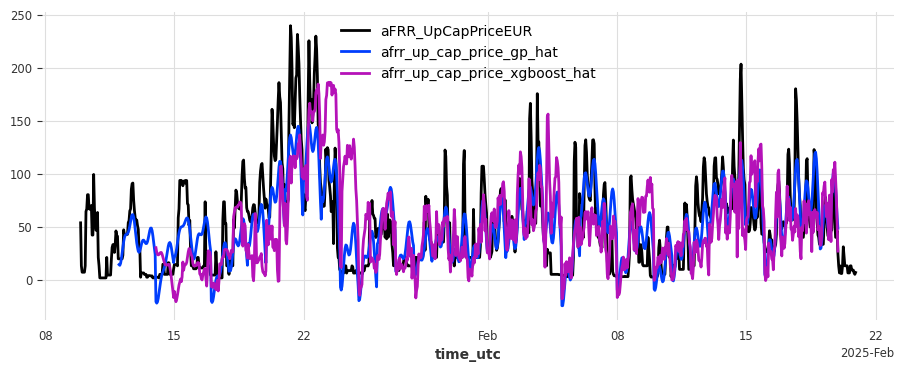

In [ ]:
afrr_pr_ts_orig_test.plot()
hist_forecasts_gp.plot()
#hist_forecasts_lr.plot()
plt.show()